In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import quandl

In [2]:
start = '07-01-2015'
end = '07-01-2017'

In [3]:
united = quandl.get('WIKI/UAL',start_date=start,end_date=end)
american = quandl.get('WIKI/AAL',start_date=start,end_date=end)

In [4]:
united.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2015-01-07,64.96,66.11,64.00,65.53,5133939.0,0.0,1.0,64.96,66.11,64.00,65.53,5133939.0
2015-01-08,65.70,67.52,65.41,66.64,6889597.0,0.0,1.0,65.70,67.52,65.41,66.64,6889597.0
2015-01-09,66.76,66.97,64.90,65.34,3488027.0,0.0,1.0,66.76,66.97,64.90,65.34,3488027.0
2015-01-12,66.16,66.85,63.84,65.92,5246008.0,0.0,1.0,66.16,66.85,63.84,65.92,5246008.0
2015-01-13,66.84,68.26,65.45,66.41,6265791.0,0.0,1.0,66.84,68.26,65.45,66.41,6265791.0


In [5]:
american.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2015-01-07,53.38,53.65,52.12,53.01,10069816.0,0.0,1.0,51.996785,52.259788,50.769435,51.636372,10069816.0
2015-01-08,53.48,54.28,53.25,53.66,9672064.0,0.0,1.0,52.094194,52.873463,51.870153,52.269529,9672064.0
2015-01-09,53.67,53.91,51.82,52.02,12290046.0,0.0,1.0,52.279270,52.513051,50.477208,50.672026,12290046.0
2015-01-12,51.06,51.45,49.20,49.58,18261336.0,0.0,1.0,49.736902,50.116796,47.925100,48.295253,18261336.0
2015-01-13,50.12,51.43,49.46,50.40,12259271.0,0.0,1.0,48.821260,50.097314,48.178362,49.094004,12259271.0


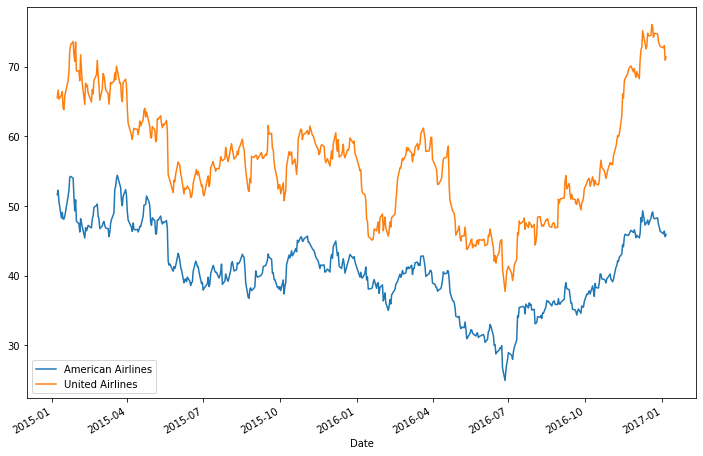

In [6]:
american['Adj. Close'].plot(label='American Airlines',figsize=(12,8))
united['Adj. Close'].plot(label='United Airlines')
plt.legend()

In [7]:
np.corrcoef(american['Adj. Close'],united['Adj. Close'])

array([[1.        , 0.92145101],
       [0.92145101, 1.        ]])

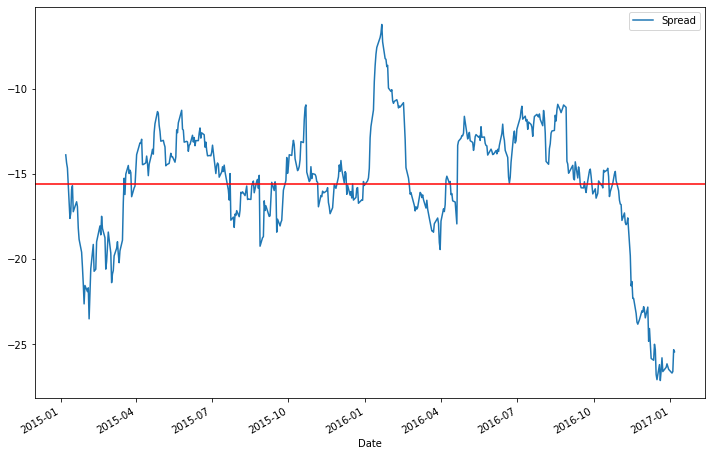

In [8]:
spread = american['Adj. Close'] - united['Adj. Close']
spread.plot(label='Spread',figsize=(12,8))
plt.axhline(spread.mean(),c='r')
plt.legend()

In [9]:
def zscore(stocks):
    return (stocks - stocks.mean()) / np.std(stocks)

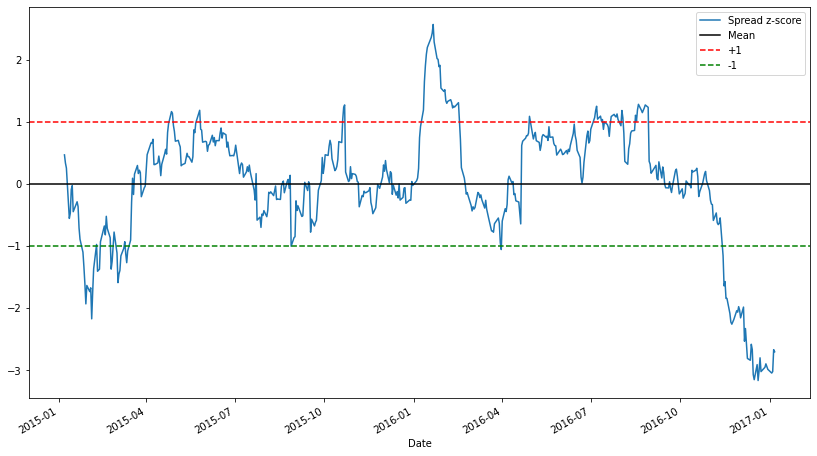

In [10]:
zscore(spread).plot(figsize=(14,8))
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, c='r', ls='--')
plt.axhline(-1.0, c='g', ls='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

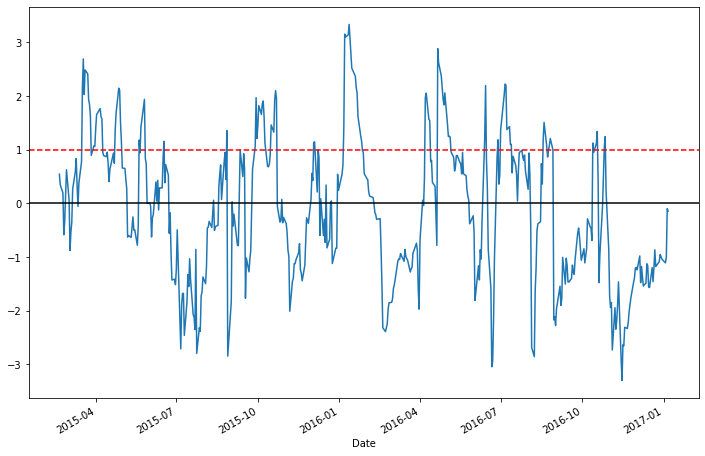

In [11]:
#1 day moving average of the price spread
spread_mavg1 = spread.rolling(1).mean()

# 30 day moving average of the price spread
spread_mavg30 = spread.rolling(30).mean()

# Take a rolling 30 day standard deviation
std_30 = spread.rolling(30).std()

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30



zscore_30_1.plot(figsize=(12,8),label='Rolling 30 day Z score')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--');

In [12]:
import numpy as np
 
def initialize(context):
    """
    Called once at the start of the algorithm.
    """   
    
    # Every day we check the pair status
    schedule_function(check_pairs, date_rules.every_day(), time_rules.market_close(minutes=60))
    
    # Our Two Airlines
    context.aa = sid(45971) #aal
    context.ual = sid(28051) #ual   
    
    # Flags to tell us if we're currently in a trade
    context.long_on_spread = False
    context.shorting_spread = False


def check_pairs(context, data):
    
    # For convenience
    aa = context.aa
    ual = context.ual
    
    # Get pricing history
    prices = data.history([aa, ual], "price", 30, '1d')
    
 
    # Need to use .iloc[-1:] to get dataframe instead of series
    short_prices = prices.iloc[-1:]
    
    # Get the long 30 day mavg
    mavg_30 = np.mean(prices[aa] - prices[ual])
    
    # Get the std of the 30 day long window
    std_30 = np.std(prices[aa] - prices[ual])
    
    # Get the shorter span 1 day mavg
    mavg_1 = np.mean(short_prices[aa] - short_prices[ual])
    
    # Compute z-score
    if std_30 > 0:
        zscore = (mavg_1 - mavg_30)/std_30
    
        # Our two entry cases
        if zscore > 0.5 and not context.shorting_spread:
            # spread = aa - ual
            order_target_percent(aa, -0.5) # short top
            order_target_percent(ual, 0.5) # long bottom
            context.shorting_spread = True
            context.long_on_spread = False
            
        elif zscore < -0.5 and not context.long_on_spread:
            # spread = aa - ual
            order_target_percent(aa, 0.5) # long top
            order_target_percent(ual, -0.5) # short bottom
            context.shorting_spread = False
            context.long_on_spread = True
            
        # Our exit case
        elif abs(zscore) < 0.1:
            order_target_percent(aa, 0)
            order_target_percent(ual, 0)
            context.shorting_spread = False
            context.long_on_spread = False
        
        record('zscore', zscore)